# 08 – Marcadores y expresión diferencial (DE) por linaje (Level2)

En este notebook trabajamos **un linaje Level1 cada vez** (T_and_NK, B, Mono_and_DC, Plasma, pDC, Platelets, RBC_and_HSC, ILC, UTC) para:
- interpretar los **clusters de Level2** (leiden_L2) dentro de ese linaje,
- explorar **paneles canónicos de Level2** (geneMarkers_level2),
- calcular **marcadores 1-vs-rest** por cluster L2 y exportarlos a .csv.

El notebook no fija todavía nombres biológicos definitivos de Level2; solo genera la evidencia (dotplots + DE) que se usará después para la anotación L2.

## 1. Contexto: marcadores y expresión diferencial dentro de un linaje

- Asumimos que el linaje ya tiene:
  - Level1 anotado (un único valor en `obs["Level1"]`),
  - clusters de Level2 (`obs["leiden_L2"]`) y un UMAP local (`obsm["X_umap_lineage"]`) generados en el Notebook 07.
- Objetivo aquí:
  - usar **paneles canónicos Level2** como guía visual,
  - calcular **genes marcadores 1-vs-rest** por cluster L2 dentro del linaje,
  - guardar tablas y objeto .h5ad listos para la anotación L2 en notebooks posteriores.

In [1]:
from pathlib import Path
import json

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

print("Scanpy:", sc.__version__)
print("AnnData:", ad.__version__)

Scanpy: 1.11.5
AnnData: 0.12.6


C:\Users\Coni\AppData\Local\Temp\ipykernel_14208\1154666483.py:9: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("Scanpy:", sc.__version__)
C:\Users\Coni\AppData\Local\Temp\ipykernel_14208\1154666483.py:10: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print("AnnData:", ad.__version__)


## 2. Organización de carpetas y selección del linaje a analizar

- Se detectan rutas estándar del proyecto:
  - `AI_Package/`, `AI_Package/markers/`, `data_processed/`, `data_processed/lineages/`.
- El usuario debe fijar explícitamente `LINEAGE` con una de las claves Level1:
  - `"T_and_NK"`, `"B"`, `"Plasma"`, `"Mono_and_DC"`, `"pDC"`, `"Platelets"`, `"RBC_and_HSC"`, `"ILC"`, `"UTC"`.
- Todas las rutas de entrada/salida de este notebook se construyen a partir de `LINEAGE`.

In [2]:
# Detectamos la carpeta raíz del proyecto asumiendo que este notebook está en "notebooks/"
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

AI_PACKAGE_DIR      = PROJECT_ROOT / "AI_Package"
MARKERS_DIR         = AI_PACKAGE_DIR / "markers"
DATA_PROCESSED_DIR  = PROJECT_ROOT / "data_processed"
LINEAGES_DIR        = DATA_PROCESSED_DIR / "lineages"
LINEAGES_DIR.mkdir(exist_ok=True)

print("Directorio del notebook:", NOTEBOOK_DIR)
print("Raíz del proyecto:", PROJECT_ROOT)
print("Carpeta AI_Package:", AI_PACKAGE_DIR)
print("Carpeta markers:", MARKERS_DIR)
print("Carpeta data_processed:", DATA_PROCESSED_DIR)
print("Carpeta lineages:", LINEAGES_DIR)

# Leemos MANIFEST.json por coherencia (aunque aquí no dependemos fuertemente de él)
manifest_path = AI_PACKAGE_DIR / "MANIFEST.json"
if manifest_path.exists():
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)
else:
    manifest = {}
    print("\n[AVISO] No se ha encontrado MANIFEST.json; se usarán valores por defecto.")

# === SELECCIONA AQUÍ EL LINAJE A ANALIZAR ===
# Usa una de las claves Level1 canónicas:
#   "T_and_NK", "B", "Plasma", "Mono_and_DC", "pDC",
#   "Platelets", "RBC_and_HSC", "ILC", "UTC"
LINEAGE = "T_and_NK"

print(f"\nLinaje seleccionado para análisis de marcadores: {LINEAGE}")

Directorio del notebook: D:\Users\Coni\Documents\TFM_CirrhosIS\notebooks
Raíz del proyecto: D:\Users\Coni\Documents\TFM_CirrhosIS
Carpeta AI_Package: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package
Carpeta markers: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package\markers
Carpeta data_processed: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed
Carpeta lineages: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages

Linaje seleccionado para análisis de marcadores: T_and_NK


**Paneles canónicos de Level2 (markers.py)**

- Se importa `AI_Package/markers/markers.py` y se extrae:
  - `geneMarkers_level2 = {Level1: {Level2: [genes]}}`.
- Si existen paneles para el linaje (`geneMarkers_level2[LINEAGE]`):
  - se muestran los subtipos Level2 esperados y sus genes,
  - estos paneles se usarán más adelante para dotplots y resúmenes por cluster.
- Si no hay paneles definidos para este linaje:
  - se avisa y el análisis se basa solo en DE data-driven.

In [3]:
import sys

# Añadimos la carpeta markers al path de Python para poder importar markers.py
if str(MARKERS_DIR) not in sys.path:
    sys.path.insert(0, str(MARKERS_DIR))

try:
    import markers  # markers.py
except ImportError as e:
    raise ImportError(
        f"No se pudo importar 'markers.py' desde {MARKERS_DIR}.\n"
        f"Error original: {e}"
    )

# Extraemos el diccionario de marcadores de Level2.
# En este proyecto, geneMarkers_level2 se ha construido a partir de los paneles del Inflammation Atlas.
geneMarkers_level2 = getattr(markers, "geneMarkers_level2", {})

if not geneMarkers_level2:
    print("[AVISO] 'geneMarkers_level2' no está definido o está vacío en markers.py.")
else:
    print("Level1 disponibles en geneMarkers_level2:")
    for l1 in geneMarkers_level2.keys():
        print(f"- {l1}")

Level1 disponibles en geneMarkers_level2:
- B
- Plasma
- Mono_and_DC
- pDC
- T_and_NK
- ILC
- Platelets
- RBC_and_HSC
- UTC


In [4]:
# Intentamos obtener los paneles de Level2 para el linaje seleccionado
l2_panels = geneMarkers_level2.get(LINEAGE, {})

if not l2_panels:
    print(f"[AVISO] No se han definido paneles de Level2 para el linaje '{LINEAGE}' en geneMarkers_level2.")
else:
    print(f"Paneles de Level2 definidos para el linaje '{LINEAGE}':")
    for l2, genes in l2_panels.items():
        print(f"\nLevel2 = {l2}")
        print(" Marcadores:", ", ".join(genes))

Paneles de Level2 definidos para el linaje 'T_and_NK':

Level2 = CD4_Naive
 Marcadores: CD4, CCR7, TCF7, LEF1, SELL, KLF2

Level2 = CD8_Naive
 Marcadores: CD8A, CD8B, CCR7, TCF7, LEF1, SELL

Level2 = CD4_Effector_Th
 Marcadores: CXCR3, GATA3, RORC, RORA, IL17A, IL17F, CXCR6, IFNG, CXCR5, CXCL13

Level2 = CD8_Effector_Cytotoxic
 Marcadores: GZMK, GZMH, PRF1, NKG7, CCL5, CCL4, ITGAE, KLRG1, CTSW

Level2 = Exhausted_T
 Marcadores: HAVCR2, LAG3, PDCD1, TIGIT, TOX, TOX2, LAYN, CTLA4

Level2 = Treg
 Marcadores: FOXP3, CTLA4, IL2RA, ICOS, TIGIT, IKZF2, GATA3, CCR7

Level2 = GammaDelta_T
 Marcadores: TRGC1, TRGC2, TRDC

Level2 = MAIT
 Marcadores: KLRB1, IL7R, SLC4A10

Level2 = NK
 Marcadores: NCAM1, FCGR3A, CX3CR1, GNLY, KLRC2, KLRD1, KLRK1, NKG7

Level2 = IFN_response_T
 Marcadores: IFI16, IFI35, IFI44, IFI44L, IFI6, IFIH1, IFIT1, IFIT2, IFIT3, IFIT5, ISG15

Level2 = Proliferative_T
 Marcadores: MKI67, TOP2A, STMN1, UBE2C, PCLAF, CENPF, CDK1


## 4. Carga del objeto de linaje con embedding y clustering L2

- Se carga el objeto de linaje con embedding L2:

  - `data_processed/lineages/TFM_CIRRHOSIS_Level1_<LINEAGE>_L2embedding.h5ad`.

- Comprobaciones:

  - `obs["Level1"]` existe y todas las células tienen `Level1 == LINEAGE`.
  - `obs["leiden_L2"]` existe (clustering principal de Level2).
- Se imprime la distribución de clusters L2 para tener una idea del tamaño de cada uno.

In [5]:
safe_l1 = LINEAGE.replace(" ", "_")
input_path = LINEAGES_DIR / f"TFM_CIRRHOSIS_Level1_{safe_l1}_L2embedding.h5ad"

if not input_path.exists():
    raise FileNotFoundError(
        f"No se encuentra el archivo de linaje con L2 embedding para '{LINEAGE}' en:\n{input_path}\n"
        "Asegúrate de haber ejecutado el notebook 07 o ajusta la ruta."
    )

adata = sc.read_h5ad(input_path)
print(adata)

# Comprobamos Level1
if "Level1" not in adata.obs.columns:
    raise KeyError("No se encontró 'Level1' en adata.obs.")

unique_l1 = adata.obs["Level1"].unique()
print("\nValores únicos de Level1 en este objeto:", unique_l1)

if len(unique_l1) != 1 or unique_l1[0] != LINEAGE:
    raise ValueError(
        f"El objeto contiene Level1 = {unique_l1}, pero esperábamos solo '{LINEAGE}'.\n"
        "Revisa qué archivo estás cargando o ajusta LINEAGE."
    )

# Comprobamos clustering L2
if "leiden_L2" not in adata.obs.columns:
    raise KeyError("No se encontró 'leiden_L2' en adata.obs. Revisa el notebook 07.")

print("\nDistribución de clusters L2 (leiden_L2):")
print(adata.obs["leiden_L2"].value_counts().sort_index())

AnnData object with n_obs × n_vars = 118426 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_r0_2', 'leiden_r0_5', 'leiden_r0_8', 'leiden_L1', 'Level1_auto_suggested', 'Level1', 'leiden_L2_r0_3', 'leiden_L2_r0_6', 'leiden_L2_r1_0', 'leiden_L2'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_varia

## 5. Matriz de expresión utilizada para DE y dotplots

- Matriz base para DE y dotplots:

  - si existe `layers["log1p_10k"]`, se copia a `adata.X` (preferida),
  - en caso contrario, se usa `adata.X` tal cual viene del archivo (se avisa).

- Se comprueba el rango numérico de la matriz usada (submatriz 100×100) para confirmar que son valores **log-normalizados** razonables.

In [6]:
# 5. Matriz de expresión utilizada para DE y dotplots

BASE_LAYER = "log1p_10k"

if BASE_LAYER in adata.layers:
    print(f"Usando la capa '{BASE_LAYER}' como matriz base (copiada a adata.X) para DE y dotplots.")
    X_layer = adata.layers[BASE_LAYER]
    # Copiamos la capa a X (puede ser dispersa)
    if hasattr(X_layer, "copy"):
        adata.X = X_layer.copy()
    else:
        adata.X = np.array(X_layer, copy=True)
else:
    print(
        f"[AVISO] No se encontró la capa '{BASE_LAYER}'. "
        "Se usará adata.X tal y como se cargó del archivo."
    )

# Inspeccionamos el rango de valores de la matriz usada
sub = adata.X[:100, :100]

# sub puede ser denso o disperso; lo convertimos a array denso pequeño
if hasattr(sub, "toarray"):
    sub = sub.toarray()

sample_values = np.asarray(sub)

print("Mínimo de la matriz utilizada:", float(sample_values.min()))
print("Máximo de la matriz utilizada:", float(sample_values.max()))

Usando la capa 'log1p_10k' como matriz base (copiada a adata.X) para DE y dotplots.
Mínimo de la matriz utilizada: 0.0
Máximo de la matriz utilizada: 3.019165395239876


## 6. Dotplots de paneles canónicos de Level2 por cluster L2

- Si hay paneles Level2 para el linaje:

  - se mapean símbolos HGNC → `var_names` reales con `markers.symbols_to_varnames`,
  - se construye `filtered_panels` solo con genes presentes en el objeto.

- Se genera un dotplot:

  - `groupby="leiden_L2"`,
  - columnas organizadas por panel Level2,
  - `standard_scale="var"` para facilitar la comparación entre genes.

- Uso principal:

  - visualizar qué clusters tienen firma de cada subtipo canónico,
  - detectar clusters mixtos o atípicos que requerirán decisiones manuales en la anotación L2.


Generando dotplot usando solo los genes mapeados presentes en este objeto...
categories: 0, 1, 2, etc.
var_group_labels: CD4_Naive, CD8_Naive, CD4_Effector_Th, etc.


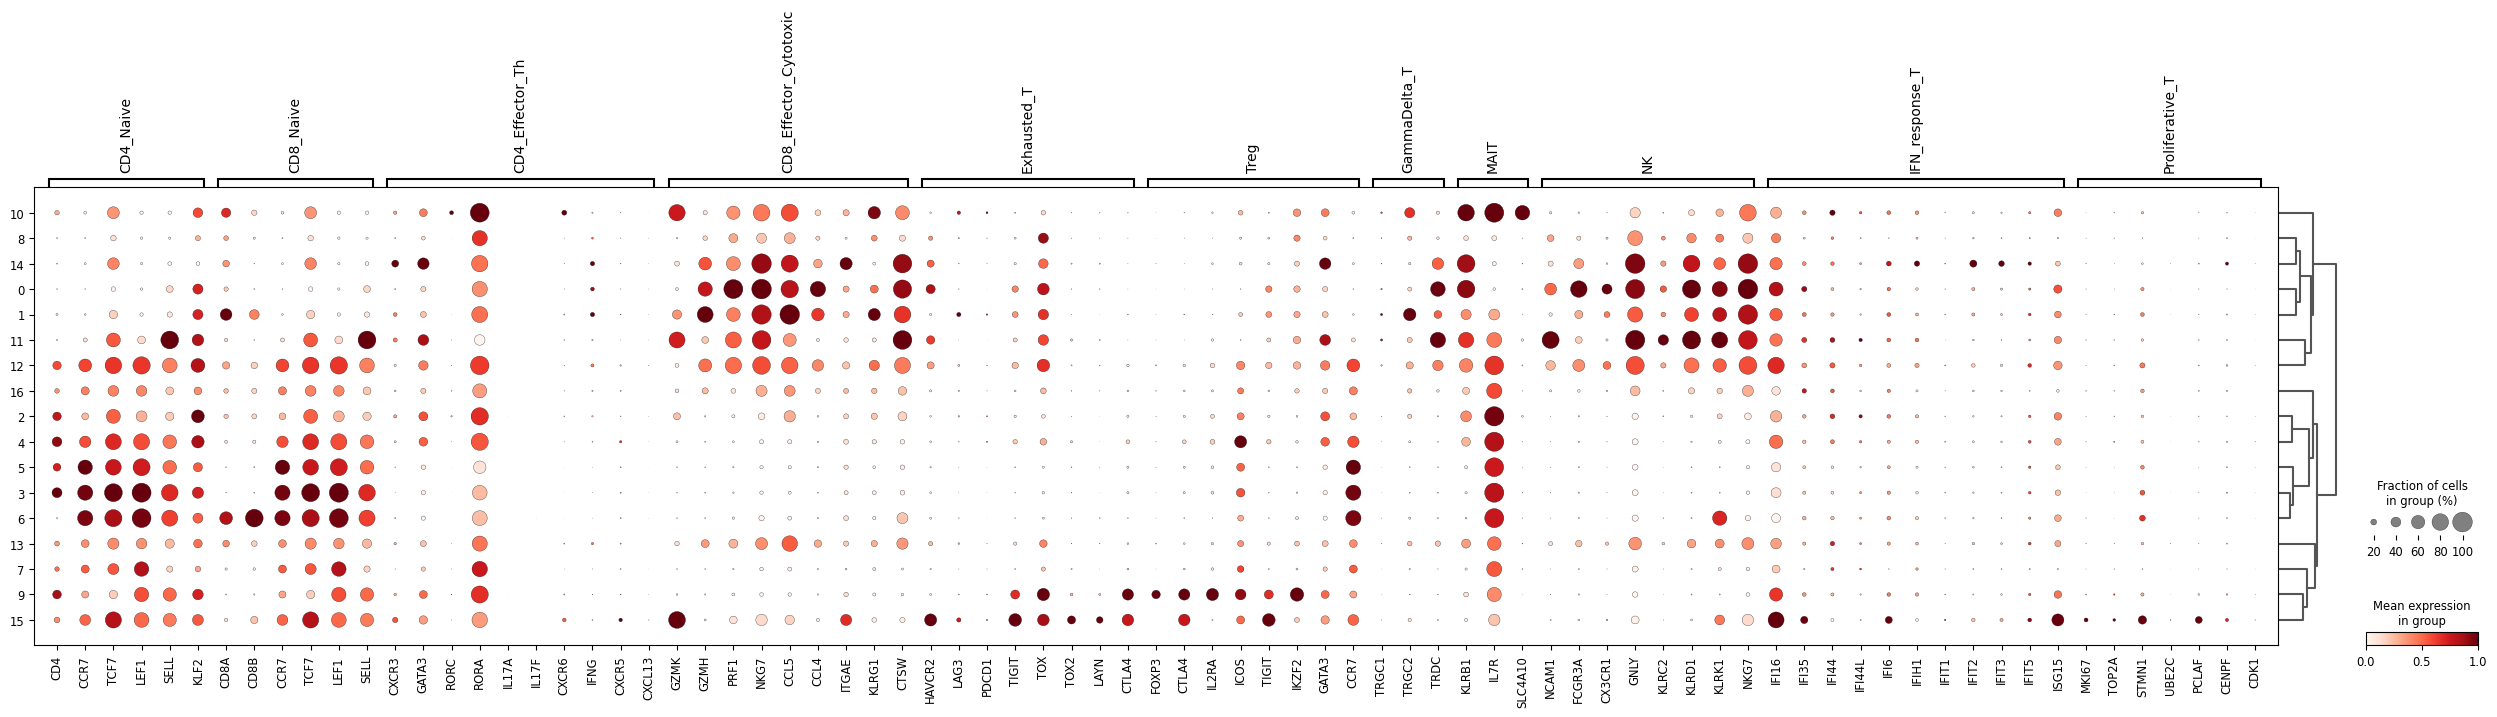

In [7]:
# 6. Dotplots de paneles canónicos de Level2 por cluster L2

if l2_panels:
    filtered_panels = {}

    for l2_name, genes in l2_panels.items():
        # Usamos el mismo helper que en el notebook 06 para mapear
        # símbolos de gen -> var_names reales del objeto
        varnames = markers.symbols_to_varnames(adata, genes)

        if varnames:
            filtered_panels[l2_name] = varnames

    if filtered_panels:
        print("\nGenerando dotplot usando solo los genes mapeados presentes en este objeto...")
        sc.pl.dotplot(
            adata,
            var_names=filtered_panels,
            groupby="leiden_L2",
            standard_scale="var",  # escala por gen para facilitar comparación
            dendrogram=True,
        )
    else:
        print(
            "Tras mapear símbolos a var_names, ningún gen de los paneles de Level2 "
            "está presente en este objeto.\n"
            "Se omite el dotplot canónico para este linaje."
        )
else:
    print(f"No hay paneles de Level2 definidos para el linaje '{LINEAGE}'. Se omite el dotplot canónico.")

Generando dotplot extra para genes T (CD3D/E/G) y NK (NCAM1) por cluster L2...


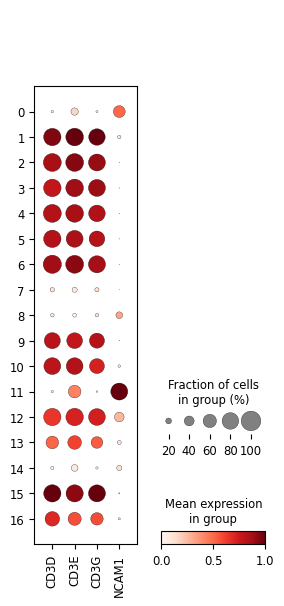


Revisa especialmente el cluster '16' en este dotplot: si coexpresa fuerte CD3* + NCAM1, lo trataremos como doublets en NB09/NB10.


In [8]:
# 6bis. (Opcional) Dotplot extra para detectar posibles doublets en T_and_NK

if LINEAGE == "T_and_NK":
    extra_genes = ["CD3D", "CD3E", "CD3G", "NCAM1"]
    extra_varnames = markers.symbols_to_varnames(adata, extra_genes)

    if extra_varnames:
        print("Generando dotplot extra para genes T (CD3D/E/G) y NK (NCAM1) por cluster L2...")
        sc.pl.dotplot(
            adata,
            var_names=extra_varnames,
            groupby="leiden_L2",
            standard_scale="var",
            dendrogram=False,
        )
        print(
            "\nRevisa especialmente el cluster '16' en este dotplot: "
            "si coexpresa fuerte CD3* + NCAM1, lo trataremos como doublets en NB09/NB10."
        )
    else:
        print(
            "[AVISO] Ninguno de CD3D/CD3E/CD3G/NCAM1 está presente en var_names; "
            "no se puede generar el dotplot extra para doublets."
        )
else:
    print("QC extra de doublets sólo se aplica cuando LINEAGE == 'T_and_NK'.")


## 7. Análisis de expresión diferencial (DE) 1-vs-rest por cluster L2

- Se ejecuta `scanpy.tl.rank_genes_groups` con:

  - `groupby="leiden_L2"`,
  - `method="wilcoxon"`,
  - `use_raw=False` (usa la matriz actual, idealmente `log1p_10k`),
  - `pts=True` para guardar porcentajes de expresión dentro/fuera del cluster.

- Resultados:

  - se guardan en `adata.uns["rank_genes_leiden_L2"]`,
  - contienen, por cada cluster L2:
    - nombres de genes, estadístico del test, p-valores, p-valores ajustados,
    - log-fold changes (si el método los devuelve),
    - `pts` / `pts_rest` (porcentaje de células positivas en grupo y resto).

- Se genera una figura rápida de top-genes (por defecto top 20) como resumen visual.

In [9]:
GROUPBY_KEY = "leiden_L2"
RANKGENES_KEY = "rank_genes_leiden_L2"

print(
    f"Calculando marcadores 1-vs-rest por cluster L2 usando scanpy.tl.rank_genes_groups "
    f"(groupby = '{GROUPBY_KEY}', method = 'wilcoxon')..."
)

sc.tl.rank_genes_groups(
    adata,
    groupby=GROUPBY_KEY,
    method="wilcoxon",
    use_raw=False,   # usamos la matriz actual (adata.X)
    n_genes=None,    # por defecto, todos los genes
    pts=True,        # porcentaje de células que expresan el gen en el grupo/resto
    key_added=RANKGENES_KEY,
)

print(f"Resultados almacenados en adata.uns['{RANKGENES_KEY}'].")

Calculando marcadores 1-vs-rest por cluster L2 usando scanpy.tl.rank_genes_groups (groupby = 'leiden_L2', method = 'wilcoxon')...
Resultados almacenados en adata.uns['rank_genes_leiden_L2'].


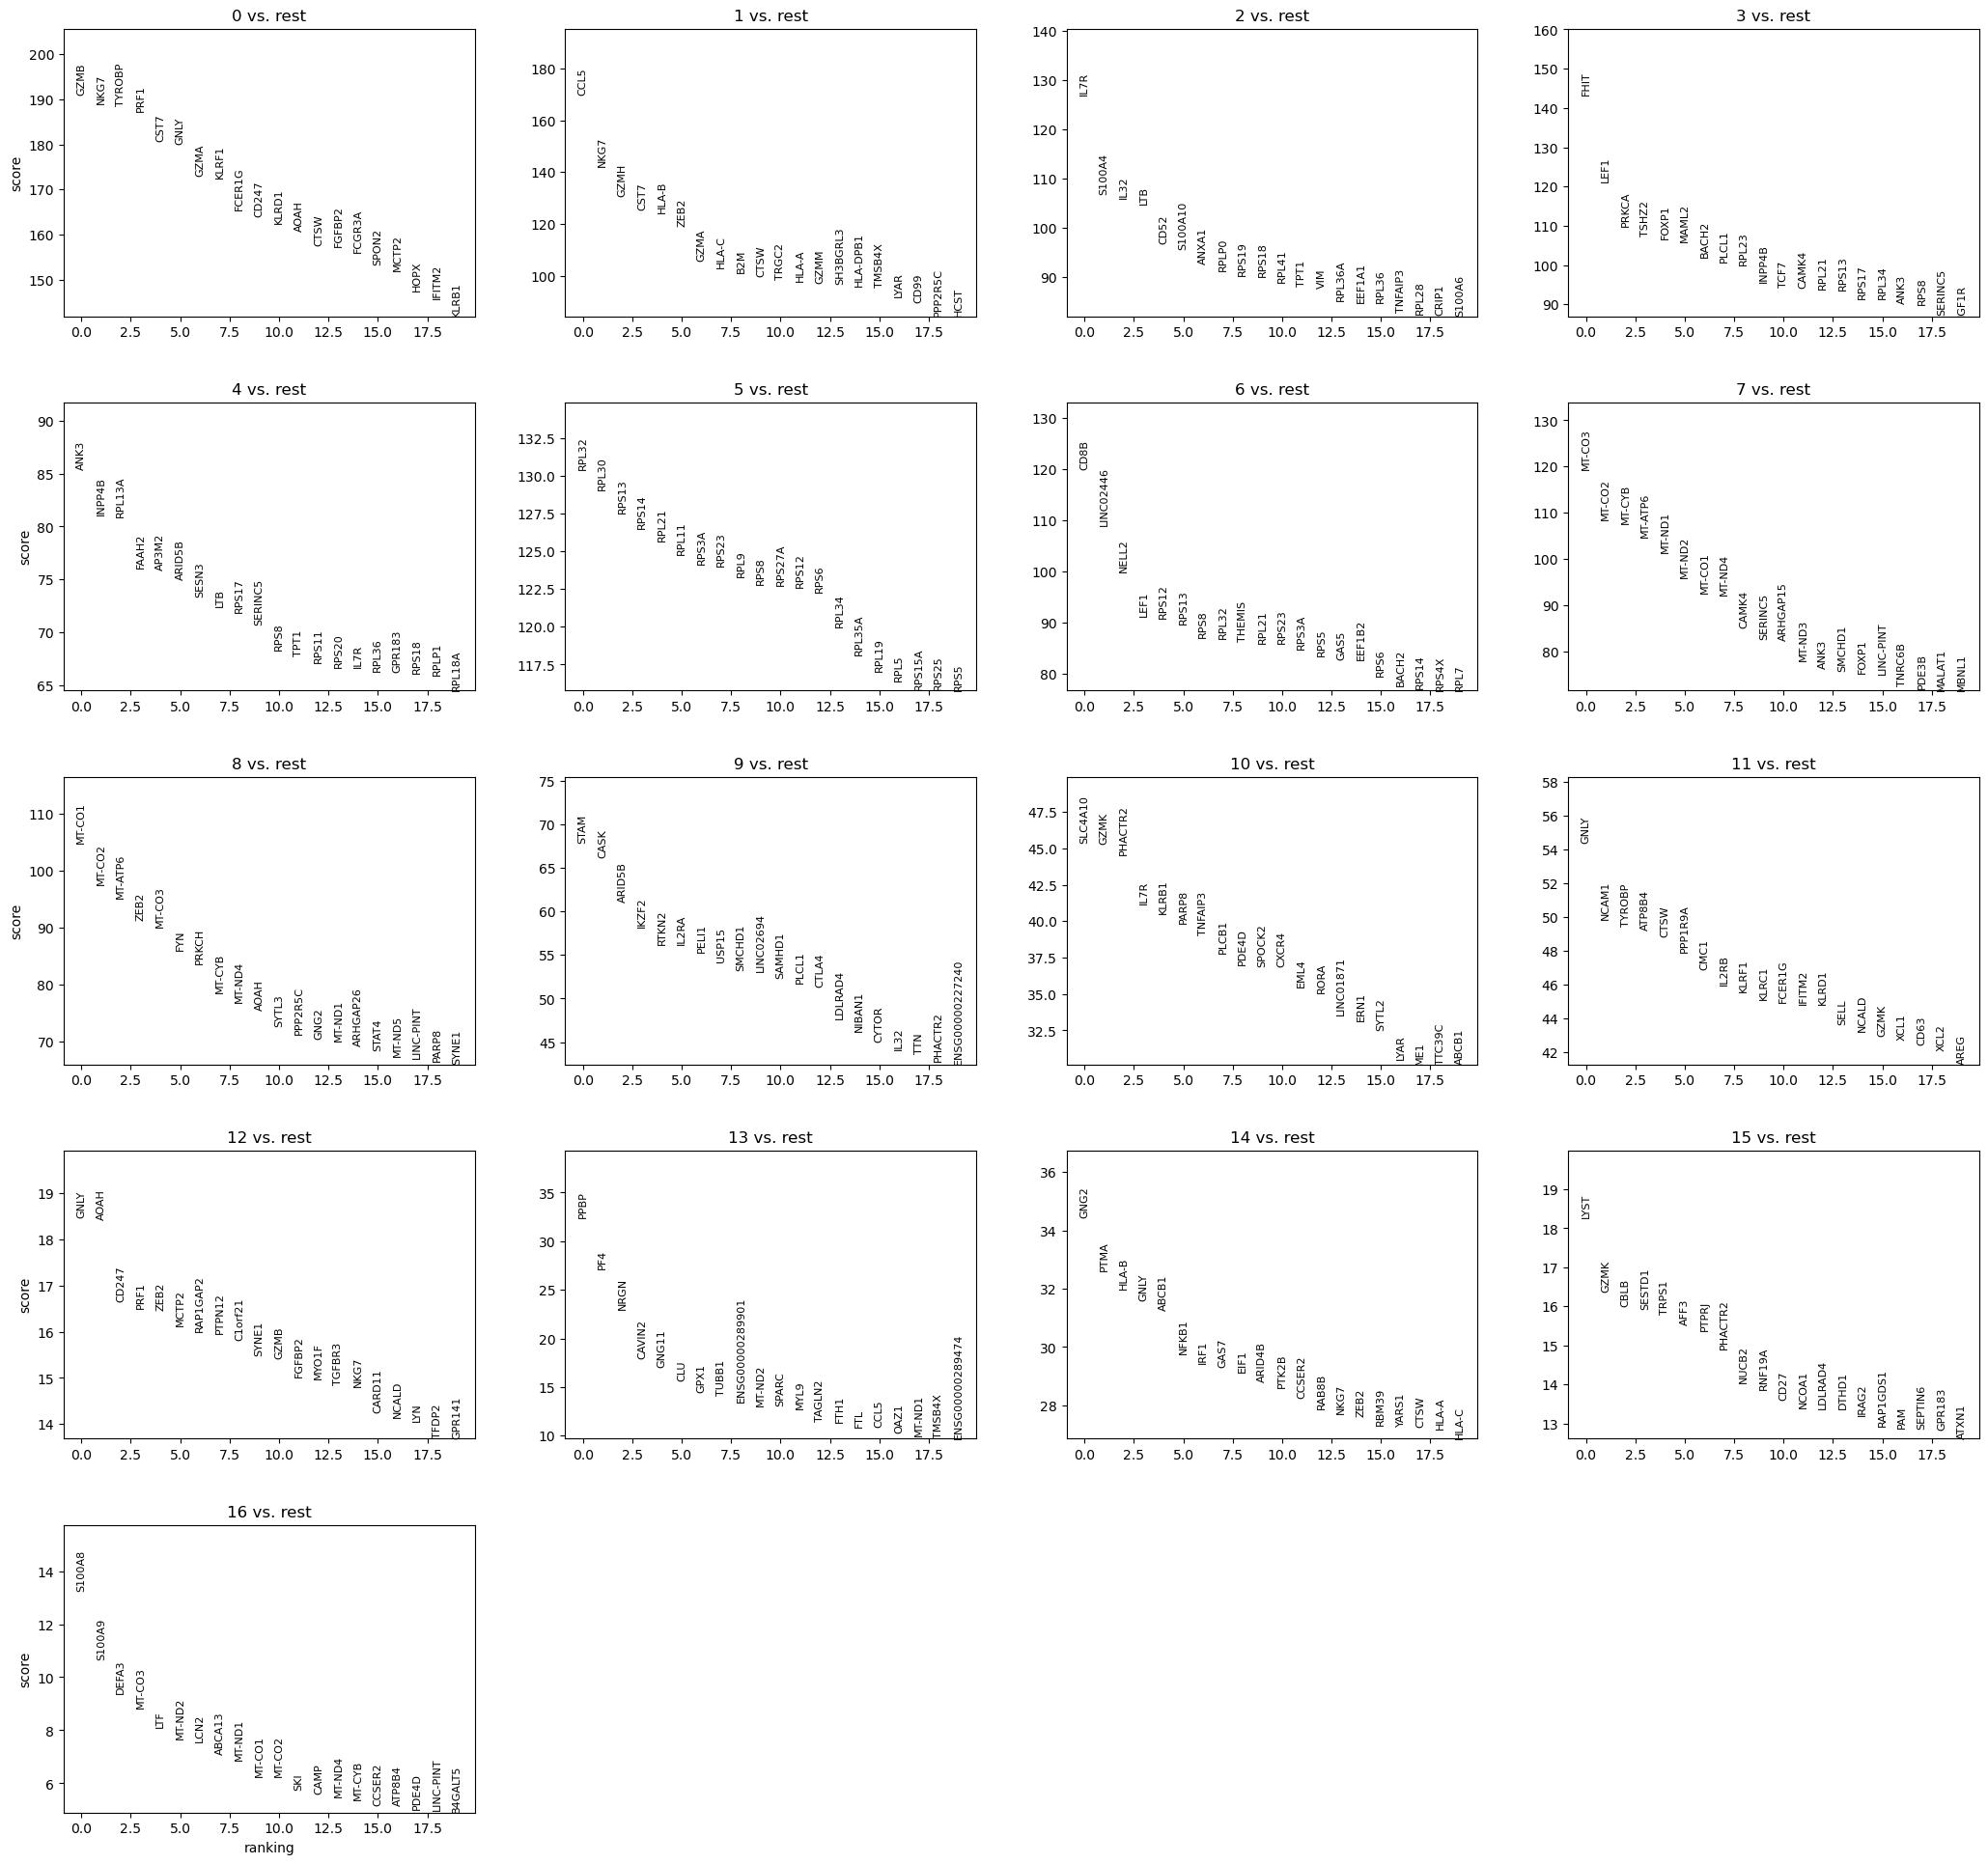

In [10]:
# Visualizamos los top genes (por ejemplo, top 20) para algunos clusters
sc.pl.rank_genes_groups(
    adata,
    key=RANKGENES_KEY,
    n_genes=20,
    sharey=False,
)

## 8. Exportación de tablas de marcadores a formato largo (`.csv`)

- Se define `rank_genes_to_long_df(...)` para convertir `adata.uns["rank_genes_leiden_L2"]` en un DataFrame “largo” con columnas:

  - `cluster` (leiden_L2),
  - `gene`, `scores`, `pvals`, `pvals_adj`,
  - `logfoldchanges`,
  - `pct_in_group`, `pct_out_group`,
  - `rank` (posición del gen dentro de la lista del cluster).

- A partir de este DataFrame se calculan resúmenes opcionales (si hay paneles Level2):

  - `panel_summary`: para cada (cluster, panel) se calcula:
    - nº de genes del panel detectados en DE,
    - logFC medio (`mean_lfc`),
    - % medio de células positivas (`mean_pct_in`),
    - logFC máximo (`max_lfc`).
  - Se derivan tablas compactas **"mejor panel por cluster"** según:
    - logFC medio (`best_by_mean_lfc`),
    - porcentaje de células positivas (`best_by_mean_pct`).
  - Estas tablas sirven como apoyo directo para construir `LEVEL2_MAP` en el notebook de anotación L2.

- Además, se listan automáticamente los **TOP_N genes** por cluster (por defecto 10) para inspección rápida en consola.

- Finalmente, se guarda una tabla de marcadores por linaje en:

  - `data_processed/lineages_markers/TFM_CIRRHOSIS_Level1_<LINEAGE>_L2markers_rank_genes.csv`.

In [11]:
def rank_genes_to_long_df(adata, key: str, groupby: str) -> pd.DataFrame:
    """
    Convierte los resultados de scanpy.tl.rank_genes_groups (en adata.uns[key])
    a un DataFrame en formato largo, con columnas:
        cluster, gene, scores, pvals, pvals_adj, logfoldchanges (si existe),
        pct_in_group (pts), pct_out_group (pts_rest), rank
    """
    rg = adata.uns[key]
    groups = rg["names"].dtype.names  # nombres de clusters/levels

    records = []
    for group in groups:
        names = rg["names"][group]
        scores = rg["scores"][group]
        pvals = rg["pvals"][group]
        pvals_adj = rg["pvals_adj"][group]

        # Algunos métodos devuelven logfoldchanges; otros no
        logfoldchanges = rg.get("logfoldchanges", None)
        if logfoldchanges is not None:
            lfc = logfoldchanges[group]
        else:
            lfc = [np.nan] * len(names)

        # Porcentaje de células que expresan el gen en grupo/resto (si está disponible)
        pts = rg.get("pts", None)
        if pts is not None:
            pct_in = pts[group]
        else:
            pct_in = [np.nan] * len(names)

        pts_rest = rg.get("pts_rest", None)
        if pts_rest is not None:
            pct_out = pts_rest[group]
        else:
            pct_out = [np.nan] * len(names)

        for rank, (gene, s, pv, pva, lf, pi, po) in enumerate(
            zip(names, scores, pvals, pvals_adj, lfc, pct_in, pct_out), start=1
        ):
            records.append({
                groupby: group,
                "cluster": group,
                "gene": gene,
                "scores": s,
                "pvals": pv,
                "pvals_adj": pva,
                "logfoldchanges": lf,
                "pct_in_group": pi,
                "pct_out_group": po,
                "rank": rank,
            })

    df = pd.DataFrame.from_records(records)
    return df

markers_df = rank_genes_to_long_df(adata, key=RANKGENES_KEY, groupby=GROUPBY_KEY)
markers_df.head()

,leiden_L2,cluster,gene,scores,pvals,pvals_adj,logfoldchanges,pct_in_group,pct_out_group,rank
0,0,0,GZMB,190.966339,0.0,0.0,5.312480,0.000000,0.00001,1
1,0,0,NKG7,189.028320,0.0,0.0,5.095971,0.000058,0.00000,2
2,0,0,TYROBP,188.649200,0.0,0.0,4.879295,0.000000,0.00001,3
3,0,0,PRF1,187.356583,0.0,0.0,4.668163,0.000000,0.00000,4
4,0,0,CST7,180.709503,0.0,0.0,4.120625,0.000000,0.00002,5


In [12]:
# 8b. Resumen numérico de paneles de Level2 por cluster (para QC / interpretación)

if "filtered_panels" not in globals() or not filtered_panels:
    print(
        "No se encontró 'filtered_panels' (paneles de Level2 mapeados a var_names) "
        "o está vacío.\nEjecuta antes la celda 6 (dotplot) y comprueba geneMarkers_level2."
    )
    panel_summary_LINEAGE = None
else:
    def summarize_panels(markers_df: pd.DataFrame, panels: dict) -> pd.DataFrame:
        """
        Calcula, para cada cluster y cada panel de Level2:
          - n_genes_found: nº de genes del panel encontrados en DE
          - mean_lfc: log fold-change medio
          - mean_pct_in: % medio de células positivas
          - max_lfc: logFC máximo del panel
        """
        rows = []
        clusters = sorted(markers_df["cluster"].unique(), key=lambda x: int(x))

        for cl in clusters:
            df_c = markers_df[markers_df["cluster"] == cl]
            for panel_name, genes in panels.items():
                sub = df_c[df_c["gene"].isin(genes)]
                if sub.empty:
                    continue
                rows.append({
                    "cluster": cl,
                    "panel": panel_name,
                    "n_genes_found": sub.shape[0],
                    "mean_lfc": sub["logfoldchanges"].mean(),
                    "mean_pct_in": sub["pct_in_group"].mean(),
                    "max_lfc": sub["logfoldchanges"].max(),
                })

        return pd.DataFrame(rows)

    panel_summary_LINEAGE = summarize_panels(markers_df, filtered_panels)

    if panel_summary_LINEAGE.empty:
        print("panel_summary_LINEAGE está vacío; revisa geneMarkers_level2 / filtered_panels.")
    else:
        panel_summary_LINEAGE = (
            panel_summary_LINEAGE
            .sort_values(["cluster", "panel"])
            .reset_index(drop=True)
        )
        print("Resumen numérico de paneles (primeras filas):")
        print(panel_summary_LINEAGE.head())


# --- Resumen compacto para interpretar y compartir ---

if panel_summary_LINEAGE is None or panel_summary_LINEAGE.empty:
    print("\n[INFO] No hay panel_summary_LINEAGE disponible; omito resumen compacto.")
else:
    # Mejor panel por cluster según logFC medio
    best_by_mean_lfc = (
        panel_summary_LINEAGE
        .loc[
            panel_summary_LINEAGE.groupby("cluster")["mean_lfc"].idxmax(),
            ["cluster", "panel", "n_genes_found", "mean_lfc", "mean_pct_in", "max_lfc"]
        ]
        .sort_values("cluster")
    )

    # Mejor panel por cluster según % de células positivas
    best_by_mean_pct = (
        panel_summary_LINEAGE
        .loc[
            panel_summary_LINEAGE.groupby("cluster")["mean_pct_in"].idxmax(),
            ["cluster", "panel", "n_genes_found", "mean_pct_in", "mean_lfc", "max_lfc"]
        ]
        .sort_values("cluster")
    )

    print("\n=== Mejor panel por cluster según logFC medio ===")
    print(best_by_mean_lfc)

    print("\n=== Mejor panel por cluster según % de células positivas ===")
    print(best_by_mean_pct)

    # Top N genes por cluster, listados automáticamente
    TOP_N = 5  # cambia a 5, 15, etc. si quieres

    clusters = sorted(markers_df["cluster"].unique(), key=lambda x: int(x))

    for cl in clusters:
        sub = markers_df[markers_df["cluster"] == cl].head(TOP_N)
        print(f"\n===== Cluster {cl} =====")
        print(sub[["cluster", "gene", "scores", "logfoldchanges",
                   "pct_in_group", "pct_out_group", "rank"]])

    # Devolvemos los resúmenes para inspección interactiva
    best_by_mean_lfc, best_by_mean_pct

Resumen numérico de paneles (primeras filas):
  cluster                   panel  n_genes_found  mean_lfc  mean_pct_in  \
0       0         CD4_Effector_Th             10 -2.381010     0.082380   
1       0               CD4_Naive              6 -3.046926     0.018828   
2       0  CD8_Effector_Cytotoxic              9  2.573294     0.011786   
3       0               CD8_Naive              6 -3.201389     0.018828   
4       0             Exhausted_T              8 -0.557546     0.013639   

    max_lfc  
0  1.855955  
1  0.078375  
2  5.095971  
3 -0.725239  
4  3.224582  

=== Mejor panel por cluster según logFC medio ===
    cluster                   panel  n_genes_found  mean_lfc  mean_pct_in  \
8         0                      NK              8  3.946494     0.041194   
16        1            GammaDelta_T              3  2.593178     0.070419   
29       10                    MAIT              3  3.938858     0.000212   
41       11                      NK              8  2.361369

In [13]:
# Creamos una subcarpeta para los resultados de marcadores por linaje
MARKERS_RESULTS_DIR = DATA_PROCESSED_DIR / "lineages_markers"
MARKERS_RESULTS_DIR.mkdir(exist_ok=True)

output_csv_path = MARKERS_RESULTS_DIR / f"TFM_CIRRHOSIS_Level1_{safe_l1}_L2markers_rank_genes.csv"

markers_df.to_csv(output_csv_path, index=False)
print("Tabla de marcadores de Level2 guardada en formato .csv en:")
print(output_csv_path)

Tabla de marcadores de Level2 guardada en formato .csv en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages_markers\TFM_CIRRHOSIS_Level1_T_and_NK_L2markers_rank_genes.csv


## 9. (Opcional) DE específica entre pares de clusters L2

- Se deja una plantilla opcional (desactivada por defecto) para DE par-a-par:

  - `ENABLE_PAIRWISE_DE = True`,
  - `GROUP_A` (cluster de interés) vs `GROUP_B` (cluster de referencia).

- Internamente llama a `rank_genes_groups` con:

  - `groupby="leiden_L2"`,
  - `groups=[GROUP_A]`,
  - `reference=GROUP_B`,
  - y guarda resultados en `adata.uns["rank_genes_leiden_L2_pair_<A>_vs_<B>"]`.

- Útil solo cuando se quiere comprobar si **dos clusters muy próximos** representan realmente subtipos distintos o deberían agruparse.

In [14]:
ENABLE_PAIRWISE_DE = False

# Define aquí los clusters L2 a comparar si activas esta sección
GROUP_A = "0"  # cluster de interés
GROUP_B = "1"  # cluster de referencia

if ENABLE_PAIRWISE_DE:
    print(f"Ejecutando DE par a par entre '{GROUP_A}' (grupo) y '{GROUP_B}' (referencia)...")
    sc.tl.rank_genes_groups(
        adata,
        groupby=GROUPBY_KEY,
        groups=[GROUP_A],
        reference=GROUP_B,
        method="wilcoxon",
        use_raw=False,
        n_genes=None,
        pts=True,
        key_added=f"{RANKGENES_KEY}_pair_{GROUP_A}_vs_{GROUP_B}",
    )
    print("Resultados almacenados en adata.uns[...] con sufijo '_pair_<A>_vs_<B>'.")
else:
    print("DE par a par desactivado (ENABLE_PAIRWISE_DE = False).")

DE par a par desactivado (ENABLE_PAIRWISE_DE = False).


## 10. Guardado del objeto de linaje con resultados de marcadores

- Se guarda un objeto AnnData por linaje con todos los resultados de este notebook:

  - `obs["leiden_L2"]` y, si existen, otros clusterings L2 auxiliares,
  - `obsm["X_umap_lineage"]` (embedding local),
  - `var["highly_variable"]` (HVG de linaje) y `var["highly_variable_global"]` (si existía),
  - `uns["rank_genes_leiden_L2"]` con los resultados completos de DE.

- Ruta de salida:

  - `data_processed/lineages/TFM_CIRRHOSIS_Level1_<LINEAGE>_L2markers.h5ad`.

- Este objeto es la entrada directa para el notebook de **anotación Level2** (asignación de nombres biológicos).

In [15]:
output_h5ad_path = LINEAGES_DIR / f"TFM_CIRRHOSIS_Level1_{safe_l1}_L2markers.h5ad"
adata.write_h5ad(output_h5ad_path)

print("Objeto de linaje con resultados de marcadores DE guardado en:")
print(output_h5ad_path)

Objeto de linaje con resultados de marcadores DE guardado en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_T_and_NK_L2markers.h5ad


## 11. Resumen de este notebook

En resumen, para un linaje concreto `LINEAGE`, este notebook:

- Importa los **paneles canónicos de Level2** (si existen) desde `markers.py`.
- Carga el objeto de linaje con **embedding y clustering L2**.
- Define la matriz de expresión base (idealmente `log1p_10k`) para DE y visualización.
- Genera **dotplots** de paneles Level2 por `leiden_L2` cuando hay paneles disponibles.
- Calcula **marcadores 1-vs-rest** por cluster L2 con `scanpy.tl.rank_genes_groups`.
- Convierte los resultados a un DataFrame largo y los exporta a **.csv** por linaje.
- Construye resúmenes numéricos panel-cluster (logFC y % positivos) que facilitan la definición posterior de `LEVEL2_MAP`.
- Guarda un objeto .h5ad enriquecido con todos estos resultados para su uso en la anotación explícita de Level2 y en la redacción de resultados del TFM.

El notebook es totalmente reutilizable: basta con cambiar `LINEAGE` y volver a ejecutarlo para obtener marcadores de cada linaje principal.